In [2]:
from Helpers import *

In [ ]:


def Linearization(dt, x,Bdyn = np.array([[0.05,0.025],[0.025,0.05]])):
    TimeConstant = 1 / 0.06  # Torque dynamics coefficient

    # Extract state variables according to the given order
    theta1, dtheta1, tau1, theta2, dtheta2, tau2 = x[:6]

    # Coriolis force
    C = np.array([
        -dtheta2 * (2 * dtheta1 + dtheta2) * a2 * np.sin(theta2),
        dtheta1**2 * a2 * np.sin(theta2)
    ])
    
    # Partial derivatives of C
    dCdte = np.array([
        -dtheta2 * (2 * dtheta1 + dtheta2) * a2 * np.cos(theta2),
        dtheta1**2 * a2 * np.cos(theta2)
    ])
    dCdos = np.array([
        -dtheta2 * 2 * a2 * np.sin(theta2),
        2 * dtheta1 * a2 * np.sin(theta2)
    ])
    dCdoe = np.array([
        (-2 * dtheta1 - 2 * dtheta2) * a2 * np.sin(theta2),
        0
    ])
    
    # Inertia matrix
    M = np.array([
        [a1 + 2 * a2 * np.cos(theta2), a3 + a2 * np.cos(theta2)],
        [a3 + a2 * np.cos(theta2), a3]
    ])
    
    Minv = np.linalg.inv(M)
    
    # Derivative of inertia matrix
    dM = np.array([
        [-2 * a2 * np.sin(theta2), -a2 * np.sin(theta2)],
        [-a2 * np.sin(theta2), 0]
    ])
    
    # Compute acceleration dependencies
    dtheta = np.array([dtheta1, dtheta2])
    tau = np.array([tau1, tau2])

    d_accel_dtheta1 = -Minv @ (dCdos + Bdyn @ np.array([1, 0]))
    d_accel_tau = Minv @ np.array([1, 0])
    d_accel_theta2 = -Minv @ (dM @ Minv @ (tau - C - Bdyn @ dtheta)) - Minv @ dCdte
    d_accel_dtheta2 = -Minv @ (dCdoe + Bdyn @ np.array([0, 1]))
    d_accel_tau2 = Minv @ np.array([0, 1])

    # Construct the Jacobian matrix
    A = np.zeros((8,8))

    # Assign known structure
    A[0, 1] = 1  # d(theta1)/d(dtheta1)
    A[3, 4] = 1  # d(theta2)/d(dtheta2)

    # Acceleration contributions
    A[1, 1] = d_accel_dtheta1[0]  # d(dtheta1)/d(dtheta1)
    A[1, 3] = d_accel_theta2[0]
    A[1, 4] = d_accel_dtheta2[0]  # d(dtheta1)/d(dtheta2)
    A[1, 2] = d_accel_tau[0]  # d(dtheta1)/d(tau1)
    A[1, 5] = d_accel_tau2[0]  # d(dtheta1)/d(tau2)

    A[4, 1] = d_accel_dtheta1[1]  # d(dtheta2)/d(dtheta1)
    A[4, 3] = d_accel_theta2[1]
    A[4, 4] = d_accel_dtheta2[1]  # d(dtheta2)/d(dtheta2)
    A[4, 2] = d_accel_tau[1]  # d(dtheta2)/d(tau1)
    A[4, 5] = d_accel_tau2[1]  # d(dtheta2)/d(tau2)

    # Torque dynamics
    A[2, 2] = -TimeConstant
    A[5, 5] = -TimeConstant


    A = np.identity(8)+dt*A
    return A


In [ ]:
from Helpers import *
def BestLQG(Duration = .6,w1 = 1e4,w2 = 1e4,w3 = 1,w4 = 1,r1 = 1e-5,r2 = 1e-5,targets = [0,55],starting_point = [0,20],plot = True,Delay = 0,Num_iter = 60,Activate_Noise = False,plotEstimation = False):


    
    dt = Duration/Num_iter
    kdelay = int(Delay/dt)
    obj1,obj2 = newton(newtonf,newtondf,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(newtonf,newtondf,1e-8,1000,starting_point[0],starting_point[1])
    TimeConstant = 1/0.06

    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])
    x0_with_delay = np.tile(x0, kdelay + 1)
    Num_Var = 8

    R = np.array([[r1,0],[0,r2]])

    Q = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    Q[:Num_Var,:Num_Var] = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
             [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
             [-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]]) 

    H = np.zeros((Num_Var,(kdelay+1)*Num_Var))
    H[:,(kdelay)*Num_Var:]= np.identity(Num_Var)

    A = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    A[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)

    B = np.zeros(((kdelay+1)*Num_Var,2))
    B[:Num_Var] = np.transpose([[0,0,dt/tau,0,0,0,0,0],[0,0,0,0,0,dt/tau,0,0]])
       
    array_x = np.zeros((Num_iter,Num_Var))
    array_xhat = np.zeros((Num_iter,Num_Var))
    y = np.zeros((Num_iter-1,Num_Var))

    array_x[0] = x0.flatten()
    array_xhat[0] = x0.flatten()

    xhat = np.copy(x0_with_delay)
    x = np.copy(x0_with_delay)

    sigma = np.zeros((Num_Var*(kdelay+1),Num_Var*(kdelay+1))) 
    J = 0
    omega = np.zeros(2)
    
    for k in range(Num_iter-1):
        Bdyn = np.array([[.05,.025],[.025,.05]])
        xcopy = np.copy(x)
        xcopy[[2,5]] = [0,0]
        A[:Num_Var,:Num_Var] = Linearization(dt,xcopy,Bdyn)
        S = Q  
        for _ in range(Num_iter-1-k):
            L = np.linalg.inv(R + B.T @ S @ B) @ B.T @ S @ A
            S = A.T @ S @( A - B @ L)
        u = - L @ xhat
        J+= u.T @ R @ u 

        C = np.array([-x[4] * (2 * x[1] + x[4]) * a2 * np.sin(x[3]) , x[1] * x[1] * a2 * np.sin(x[3])])
        M = np.array([[a1 + 2 * a2 * np.cos(x[3]), a3 + a2 * np.cos(x[3])],[a3 + a2 * np.cos(x[3]), a3]])

        Omega_sens, Omega_measure, motor_noise, measure_noise = NoiseAndCovMatrix(M, Num_Var, kdelay, Linear = True,Var = 1e-6)
        #Omega_sens = np.diag(np.ones(Num_Var))*1e-6
        #Omega_measure = np.diag(np.ones(Num_Var))*1e-7
        y[k] = (H @ x).flatten()
        if Activate_Noise == True : y[k] += measure_noise

        sigma = np.zeros((Num_Var*(kdelay+1),Num_Var*(kdelay+1))) 
        for _ in range(Num_iter-1):
        
            K = A @ sigma @ H.T @ np.linalg.inv( H @ sigma @ H.T + Omega_measure)
            sigma = Omega_sens + (A - K @ H) @ sigma @ A.T
        
        xhat = A @ xhat + B @ u + K @ (y[k] - H @ xhat)
        #print(xhat[:8])
        
        omega += dt * np.linalg.solve(M, ((x[[2, 5]]) - C - Bdyn @ omega))
        x_new = np.array([
            x[0] + dt * x[1],  omega[0],  x[2] + dt * TimeConstant * (u[0] - x[2]),
            x[3] + dt * x[4],  omega[1],  x[5] + dt * TimeConstant * (u[1] - x[5]),
            x[6], x[7]
        ])

        # Concatenate with remaining x values
        x = np.concatenate((x_new, x[:-Num_Var]))

        if Activate_Noise : 

            x[[2,5]] += motor_noise[1]

        array_xhat[k+1] = xhat[:Num_Var].flatten()
        array_x[k+1] = x[:Num_Var].flatten()

        #print(array_x[k-1,2],((array_x[k]-array_x[k-1])/dt)[1])   

#Plot
    J+= x.T@Q@x
    
    x_nonlin = array_x.T[:,:][:,::1]
    X = np.cos(x_nonlin[0]+x_nonlin[3])*33+np.cos(x_nonlin[0])*30
    Y = np.sin(x_nonlin[0]+x_nonlin[3])*33+np.sin(x_nonlin[0])*30

    if plot:
        plt.plot(X,Y,color = "green",label = "LQG",linewidth = .8)
        plt.axis("equal")
        tg = np.array([obj1,obj2])
        plt.scatter(np.array([ToCartesian(tg)[0]]),np.array([ToCartesian(tg)[1]]),color = "black")
        if plotEstimation :
            x_nonlin = array_xhat.T[:,1:][:,::1]
            X2 = np.cos(x_nonlin[0]+x_nonlin[3])*33+np.cos(x_nonlin[0])*30
            Y2 = np.sin(x_nonlin[0]+x_nonlin[3])*33+np.sin(x_nonlin[0])*30
            plt.plot(X2,Y2,color = "black",label = "Estimation",linewidth = .8,linestyle ="--",alpha = .5)
    return X,Y,u,x_nonlin

[ 0.40606785  0.          0.14403876  2.15316056  0.         -0.07215123
  0.87936375  1.30976114]
[ 0.40606785  0.01879913  0.25852839  2.15316056 -0.03483274 -0.12996331
  0.87936375  1.30976114]
[ 0.40623862  0.05155273  0.34819825  2.15292119 -0.09412119 -0.17519142
  0.87936375  1.30976114]
[ 0.4067157   0.09454668  0.41719831  2.15225442 -0.17018809 -0.21009415
  0.87936375  1.30976114]
[ 0.40760528  0.14494974  0.46902408  2.15101442 -0.25744277 -0.23679267
  0.87936375  1.30976114]
[ 0.40898911  0.20060422  0.50656782  2.14908927 -0.35186117 -0.25709445
  0.87936375  1.30976114]
[ 0.41092867  0.25986062  0.53220328  2.14639409 -0.45057863 -0.27247683
  0.87936375  1.30976114]
[ 0.4134686   0.32145104  0.54787193  2.14286519 -0.55158079 -0.28412037
  0.87936375  1.30976114]
[ 0.4166396   0.38439311  0.55516037  2.13845543 -0.65347239 -0.29295355
  0.87936375  1.30976114]
[ 0.42046078  0.44791779  0.55536676  2.13313041 -0.75530506 -0.2996955
  0.87936375  1.30976114]
[ 0.4249415

(np.float64(-0.831276463914173),
 np.float64(0.20748146766593684),
 np.float64(28.99999999980164),
 np.float64(51.00000000000944))

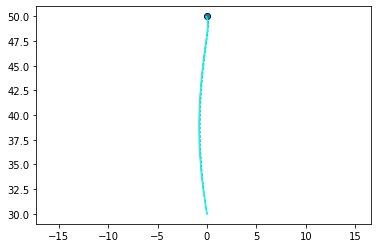

In [5]:

from Helpers import *
plt.axis("equal")
#x,y,u,z=BestLQG(Duration=.6,Num_iter=30,w1=1e8,w2 = 1e8,starting_point=[0,40],targets=tg,MultipleLinearization=True,plot = False,Activate_Noise=True)
    #plt.plot(x,y,color = "red")
tg = [0,50]
x,y,u,z=BestLQG(Duration=.6,Num_iter=60,starting_point=[0,30],r1 = 1e-5,r2 = 1e-5,targets=tg,plot = True,plotEstimation=True)

plt.plot(x,y,color = "cyan")
plt.scatter([tg[0]],[tg[1]],s = 20)
plt.axis("equal")

In [34]:
ts = .879363747 
te = 1.30976114
print(33*np.cos(ts+te)+30*np.cos(ts),33*np.sin(ts+te)+30*np.sin(ts))


-1.9636392067923225e-08 50.000000000623864


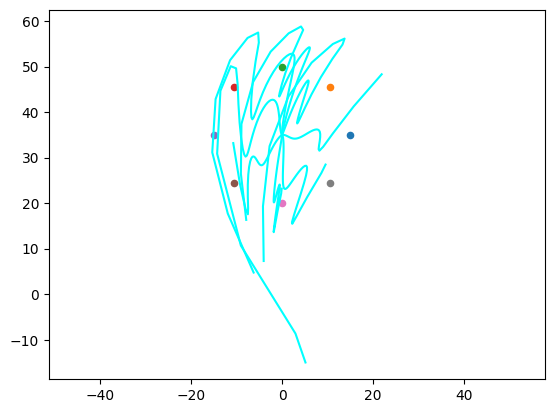

In [8]:
plt.axis("equal")
 
Bdyn = np.array([[0.05,0.025],[0.025,0.05]])
for angles in np.linspace(0,2*pi,9)[:-1] :
    tg = [cos(angles)*15,35+sin(angles)*15]
    #x,y,u,z=BestLQG(Duration=.6,Num_iter=30,w1=1e8,w2 = 1e8,starting_point=[0,40],targets=tg,MultipleLinearization=True,plot = False,Activate_Noise=True)
    #plt.plot(x,y,color = "red")
    x,y,u,z=BestLQG(Duration=.6,Num_iter=60,w1=1e4,w2 = 1e4,w3 = 1,w4 =1,r1 = 1e-5,r2 = 1e-5,starting_point=[0,35],targets=tg,plot = False,Activate_Noise=False)
    plt.plot(x,y,color = "cyan")
    plt.scatter([tg[0]],[tg[1]],s = 20)
    plt.axis("equal")

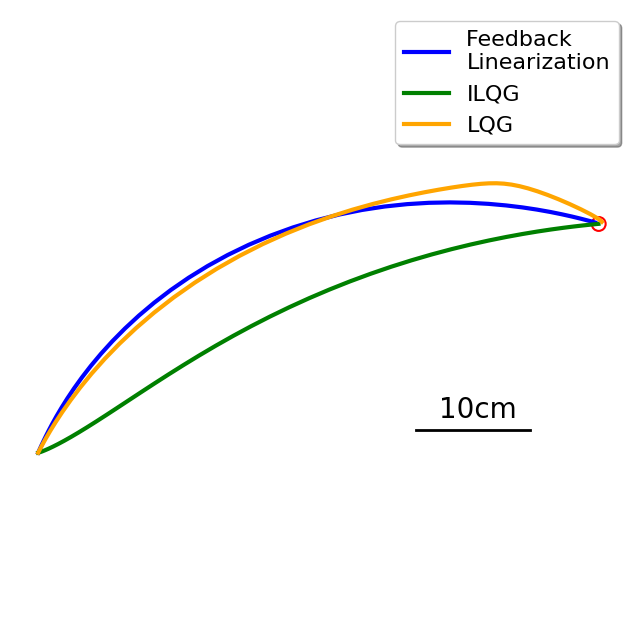

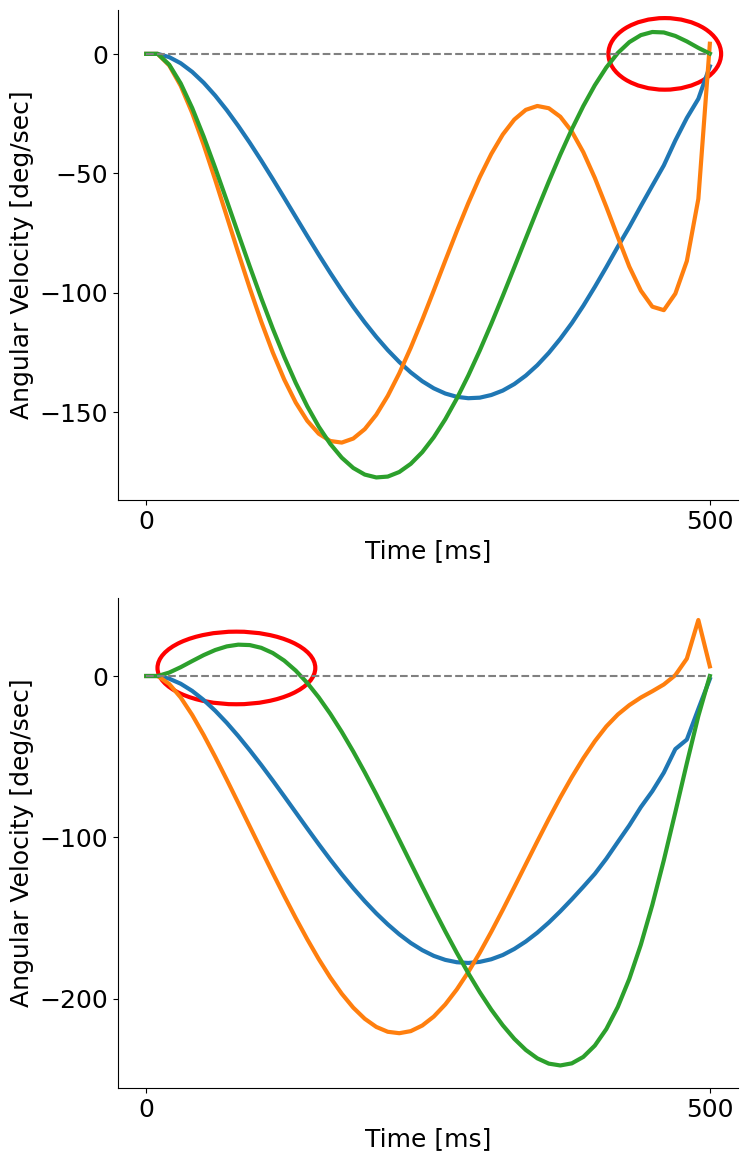

In [7]:
from ILQGController import *
from FLController import *
from matplotlib.patches import Ellipse

MovementTime = .5
NumIteration = int(MovementTime*100)
Time = np.linspace(0,MovementTime*1000,NumIteration)
plt.figure(figsize = (8,8))
xFL,yFL,j,xfl = Feedback_Linearization(Duration=MovementTime,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=NumIteration,starting_point=[-23,28],targets=[26,48],ShowJ=True,plot = False,Delay = .06,Activate_Noise=True)
xILQG,yILQG,u,zilqg=ILQG(MovementTime,1e7,1e3,1e-5,[26,48],NumIteration,[-23,28],plot = False,Delay = .06,Noise=True)
xLQG,yLQG,u,z=BestLQG(Duration=MovementTime,Num_iter=NumIteration,starting_point=[-23,28],targets=[26,48],plot = False,Delay = .06,Activate_Noise=True)
plt.plot(xFL,yFL,color = "blue",label = "Feedback \nLinearization",linewidth = 3)
plt.plot(xILQG,yILQG,color = "green",label = "ILQG",linewidth = 3)
plt.plot(xLQG,yLQG,color = "orange",label = "LQG",linewidth = 3)
plt.axis("equal")
plt.yticks([20,40,60])
plt.xticks([-20,0,20])
plt.scatter([26],[48],edgecolors='red', facecolors='none', s=100, linewidth=1.5)
ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.axis("off")
plt.plot([10,20],[30,30],color = "black",linewidth = 2)
plt.text(12,31,"10cm",fontsize = 20)
MultipleLabel(title="")
plt.show()

fig,ax = plt.subplots(2,figsize = (8,14))

for k in range(2):
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['right'].set_visible(False)
    ax[k].tick_params(axis='both', labelsize=18)
    ax[k].set_xlabel("Time [ms]",fontsize = 18)
    ax[k].set_ylabel("Angular Velocity [deg/sec]",fontsize = 18)
ax[0].plot(Time,xfl[:,2]/pi*180,label="FL",linewidth = 3)
ax[0].plot(Time,z[1]/pi*180,label = "LQG",linewidth = 3)
ax[0].plot(Time,zilqg[:,2]/pi*180,label = "ILQG",linewidth = 3)
ax[0].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")
ax[0].set_yticks([0,-50,-100,-150])
ax[0].set_xticks([0,MovementTime*1000])
ax[1].set_xticks([0,MovementTime*1000])
ax[1].set_yticks([0,-100,-200])
ellipse = Ellipse(xy=(460,0), width=100, height=30, edgecolor='red', facecolor='none', linewidth=3)

# Add the ellipse to the plot
ax[0].add_patch(ellipse)



ax[1].plot(Time,xfl[:,3]/pi*180,label="FL",linewidth = 3)
ax[1].plot(Time,z[4]/pi*180,label = "LQG",linewidth = 3)
ax[1].plot(Time,zilqg[:,3]/pi*180,label = "ILQG",linewidth = 3)
ax[1].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")
ellipse = Ellipse(xy=(80,5), width=140, height=45, edgecolor='red', facecolor='none', linewidth=3)

# Add the ellipse to the plot
ax[1].add_patch(ellipse)
#MultipleLabel(title = "")
#x,y,u=BestLQG(Duration=.6,Num_iter=120,MultipleLinearization=True)

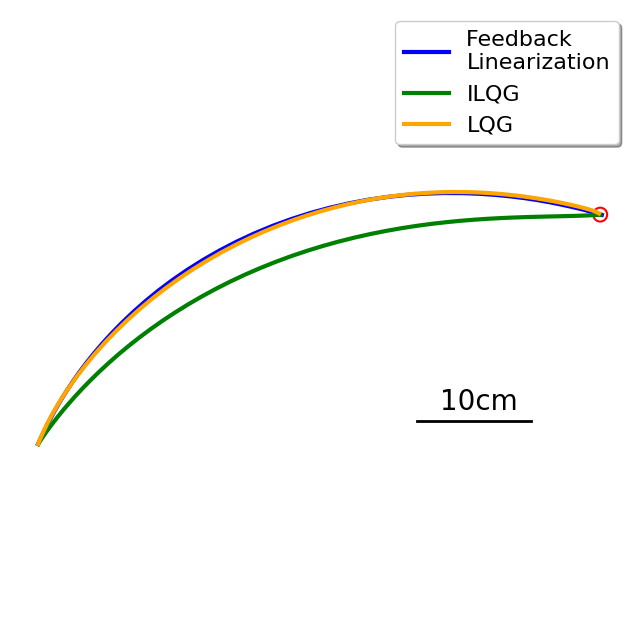

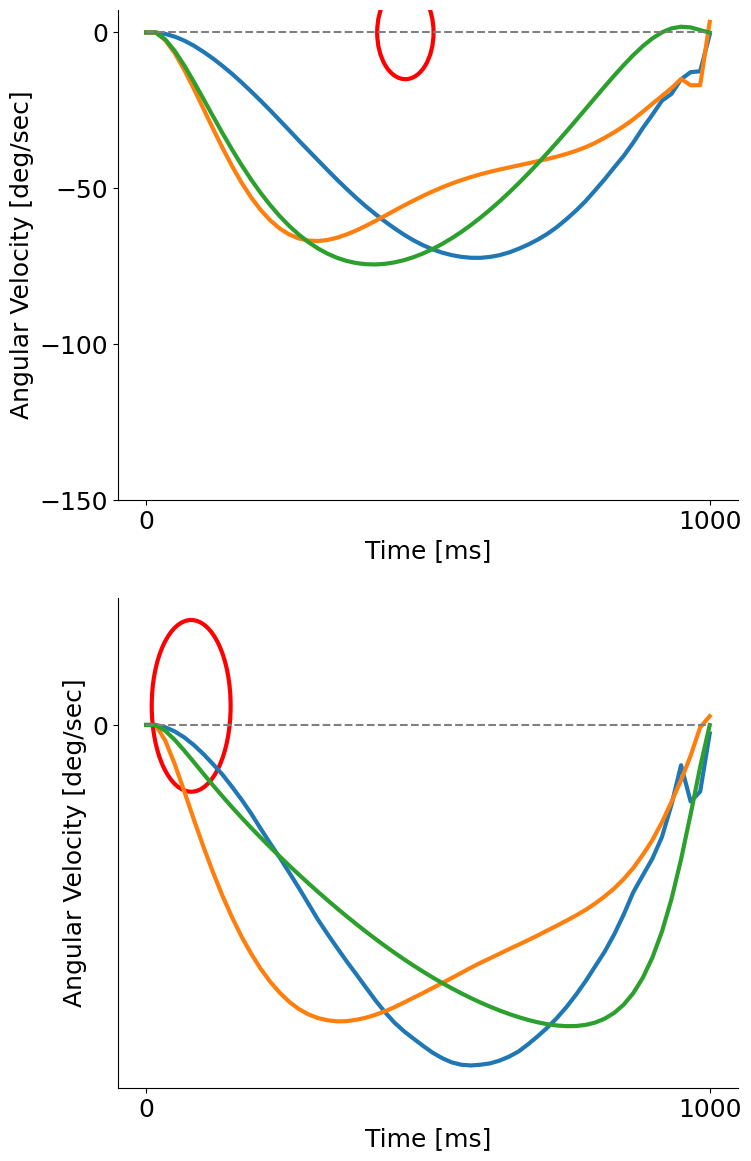

In [5]:
from ILQGController import *
from FLController import *
from matplotlib.patches import Ellipse

MovementTime = 1
NumIteration = int(MovementTime*60)
Time = np.linspace(0,MovementTime*1000,NumIteration)
plt.figure(figsize = (8,8))
xFL,yFL,j,xfl = Feedback_Linearization(Duration=MovementTime,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=NumIteration,starting_point=[-23,28],targets=[26,48],ShowJ=True,plot = False,Delay = .06,Activate_Noise=True)
xILQG,yILQG,u,zilqg=ILQG(MovementTime,1e7,1e3,1e-5,[26,48],NumIteration,[-23,28],plot = False,Delay = .06,Noise=True)
xLQG,yLQG,u,z=BestLQG(Duration=MovementTime,Num_iter=NumIteration,starting_point=[-23,28],targets=[26,48],plot = False,Delay = .06,Activate_Noise=True)
plt.plot(xFL,yFL,color = "blue",label = "Feedback \nLinearization",linewidth = 3)
plt.plot(xILQG,yILQG,color = "green",label = "ILQG",linewidth = 3)
plt.plot(xLQG,yLQG,color = "orange",label = "LQG",linewidth = 3)
plt.axis("equal")
plt.yticks([20,40,60])
plt.xticks([-20,0,20])
plt.scatter([26],[48],edgecolors='red', facecolors='none', s=100, linewidth=1.5)
ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.axis("off")
plt.plot([10,20],[30,30],color = "black",linewidth = 2)
plt.text(12,31,"10cm",fontsize = 20)
MultipleLabel(title="")
plt.show()

fig,ax = plt.subplots(2,figsize = (8,14))

for k in range(2):
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['right'].set_visible(False)
    ax[k].tick_params(axis='both', labelsize=18)
    ax[k].set_xlabel("Time [ms]",fontsize = 18)
    ax[k].set_ylabel("Angular Velocity [deg/sec]",fontsize = 18)
ax[0].plot(Time,xfl[:,2]/pi*180,label="FL",linewidth = 3)
ax[0].plot(Time,z[1]/pi*180,label = "LQG",linewidth = 3)
ax[0].plot(Time,zilqg[:,2]/pi*180,label = "ILQG",linewidth = 3)
ax[0].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")
ax[0].set_yticks([0,-50,-100,-150])
ax[0].set_xticks([0,MovementTime*1000])
ax[1].set_xticks([0,MovementTime*1000])
ax[1].set_yticks([0,-100,-200])
ellipse = Ellipse(xy=(460,0), width=100, height=30, edgecolor='red', facecolor='none', linewidth=3)

# Add the ellipse to the plot
ax[0].add_patch(ellipse)



ax[1].plot(Time,xfl[:,3]/pi*180,label="FL",linewidth = 3)
ax[1].plot(Time,z[4]/pi*180,label = "LQG",linewidth = 3)
ax[1].plot(Time,zilqg[:,3]/pi*180,label = "ILQG",linewidth = 3)
ax[1].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")
ellipse = Ellipse(xy=(80,5), width=140, height=45, edgecolor='red', facecolor='none', linewidth=3)

# Add the ellipse to the plot
ax[1].add_patch(ellipse)

In [5]:
def Rearrange_state(x):
    return np.array([x[0],x[2],x[4],x[1],x[3],x[5],x[6],x[7]])
def Cost_Function(w1,w2,r,z,u,rearrange = False,targetpenalty = True):
    if len(z) != 8 : raise ValueError 
    if rearrange : z = Rearrange_state(z)
    R = np.array([[r,0],[0,r]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w2,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w1,0,0,0,-w1],[0,0,0,0,w2,0,0,0],[0,0,0,0,0,0,0,0],
               [-w1,0,0,0,0,0,w1,0],[0,0,0,-w1,0,0,0,w1]])
    J = 0
    for i in range(u.shape[0]):
        J+= u[i].T@R@u[i]
    if targetpenalty : J+=z.T@Q@z
    return int(J*1000)/1000
def toPolar(targets):
    obj1,obj2 = newton(fnewton,dfnewton,1e-8,1000,targets[0],targets[1])
    return np.array([obj1,obj2])


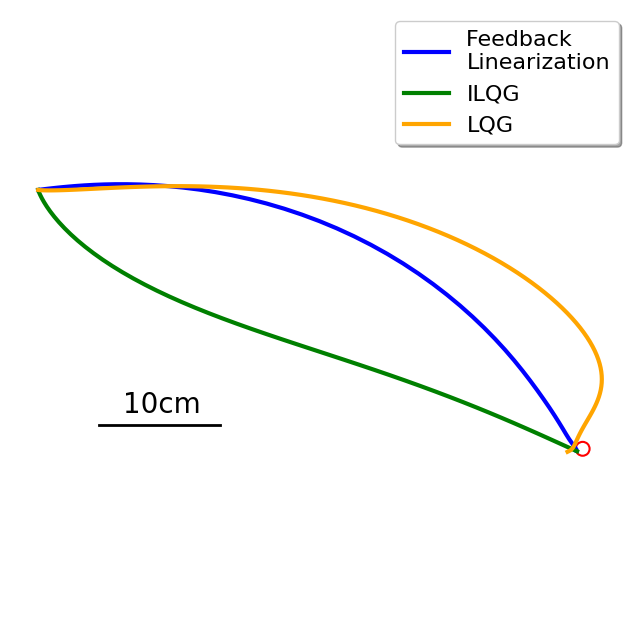

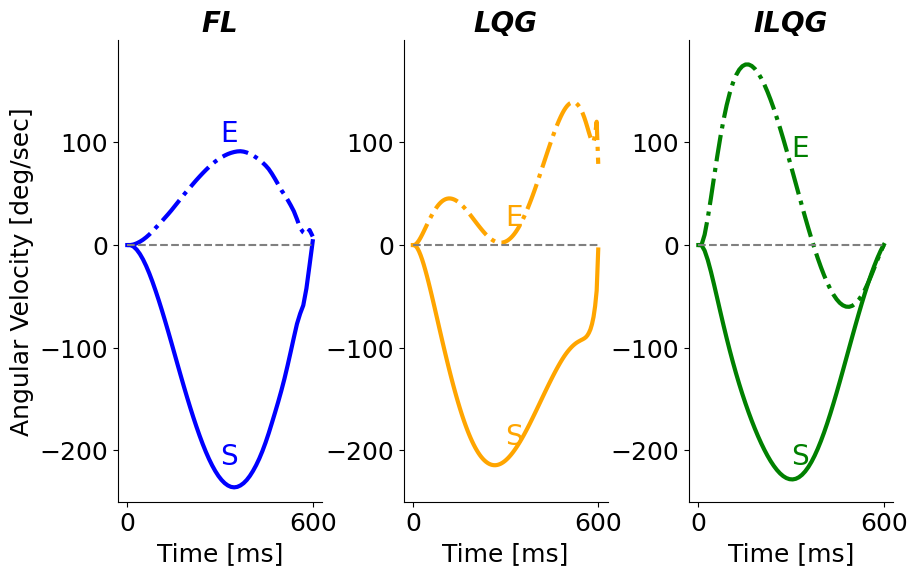

In [6]:
from ILQGController import *
from FLController import *
from matplotlib.patches import Ellipse
st = ToCartesian(np.array([70,70])/180*pi)
tg = ToCartesian(np.array([-10,100])/180*pi)
MovementTime = .6
NumIteration = int(MovementTime*100)
Time = np.linspace(0,MovementTime*1000,NumIteration)
plt.figure(figsize = (8,8))

xFL,yFL,jFL,xfl = Feedback_Linearization(Duration=MovementTime,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=NumIteration,starting_point=st,targets=tg,ShowJ=True,plot = False,Delay = .06,Activate_Noise=True)
xILQG,yILQG,uilqg,zilqg=ILQG(MovementTime,1e7,1e3,1e-5,tg,NumIteration,st,plot = False,Delay = .06,Noise=True)
xLQG,yLQG,ulqg,zlqg=BestLQG(Duration=MovementTime,Num_iter=120,starting_point=st,targets=tg,plot = False,Delay = .06,Activate_Noise=True,MultipleLinearization=False)

jILQG = Cost_Function(1e7,1e3,1e-5,np.concatenate((zilqg[-1,:6],toPolar(tg))),uilqg,rearrange=True)
jLQG = Cost_Function(1e7,1e3,1e-5,zlqg[:,-1],ulqg)
jFL = int(jFL*1000)/1000

plt.plot(xFL,yFL,color = "blue",label = "Feedback \nLinearization",linewidth = 3)
plt.plot(xILQG,yILQG,color = "green",label = "ILQG",linewidth = 3)
plt.plot(xLQG,yLQG,color = "orange",label = "LQG",linewidth = 3)
plt.axis("equal")
plt.yticks([20,40,60])
plt.xticks([-20,0,20])
plt.scatter([30],[28],edgecolors='red', facecolors='none', s=100, linewidth=1.5)
ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.axis("off")
plt.plot([-10,0],[30,30],color = "black",linewidth = 2)
plt.text(-8,31,"10cm",fontsize = 20)
MultipleLabel(title="")
plt.show()

fig,ax = plt.subplots(1,3,figsize = (10,6))
Decal = 15
ft = 20

ax[0].plot(Time,xfl[:,2]/pi*180,label="Shoulder",linewidth = 3,color = "blue")
ax[1].plot(np.linspace(0,MovementTime*1000,120),zlqg[1]/pi*180,label = "Shoulder",linewidth = 3,color = "orange")
ax[2].plot(Time,zilqg[:,2]/pi*180,label = "Shoulder",linewidth = 3,color = "green")



ax[0].text(300,(xfl[:,2]/pi*180)[len(xfl[:,2])//2]+Decal,"S",color = "blue",fontsize = ft)
ax[1].text(300,(zlqg[1]/pi*180)[len(zlqg[1])//2]+Decal,"S",color = "orange",fontsize = ft)
ax[2].text(300,(zilqg[:,2]/pi*180)[len(zilqg[:,2])//2]+Decal,"S",color = "green",fontsize = ft)

ax[0].text(300,(xfl[:,3]/pi*180)[len(xfl[:,3])//2]+Decal,"E",color = "blue",fontsize = ft)
ax[1].text(300,(zlqg[4]/pi*180)[len(zlqg[4])//2]+Decal,"E",color = "orange",fontsize = ft)
ax[2].text(300,(zilqg[:,3]/pi*180)[len(zilqg[:,3])//2]+Decal,"E",color = "green",fontsize = ft)
ft = 20
ax[0].set_title("FL",fontsize = ft,fontweight = "bold",style = "italic")
ax[1].set_title("LQG",fontsize = ft,fontweight = "bold",style = "italic")
ax[2].set_title("ILQG",fontsize = ft,fontweight = "bold",style = "italic")





ax[0].plot(Time,xfl[:,3]/pi*180,label="Elbow",linewidth = 3,color = "blue",linestyle = "-.")
ax[1].plot(np.linspace(0,MovementTime*1000,120),zlqg[4]/pi*180,label = "Elbow",linewidth = 3,color = "orange",linestyle = "-.")
ax[2].plot(Time,zilqg[:,3]/pi*180,label = "Elbow",linewidth = 3,color = "green",linestyle = "-.")
ax[0].set_ylabel("Angular Velocity [deg/sec]",fontsize = 18)
for k in range(3):
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['right'].set_visible(False)
    ax[k].tick_params(axis='both', labelsize=18)
    ax[k].set_xlabel("Time [ms]",fontsize = 18)
    ax[k].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")
    ax[k].set_yticks([-200,-100,0,100])
    ax[k].set_ylim(-250,200)
    ax[k].set_xticks([0,MovementTime*1000])

plt.subplots_adjust(wspace=0.4,hspace = 0.3)
#MultipleLabel(title = "")

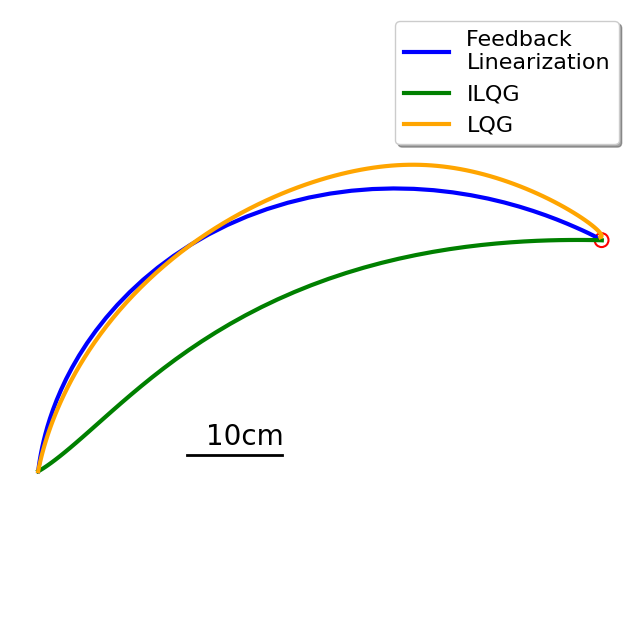

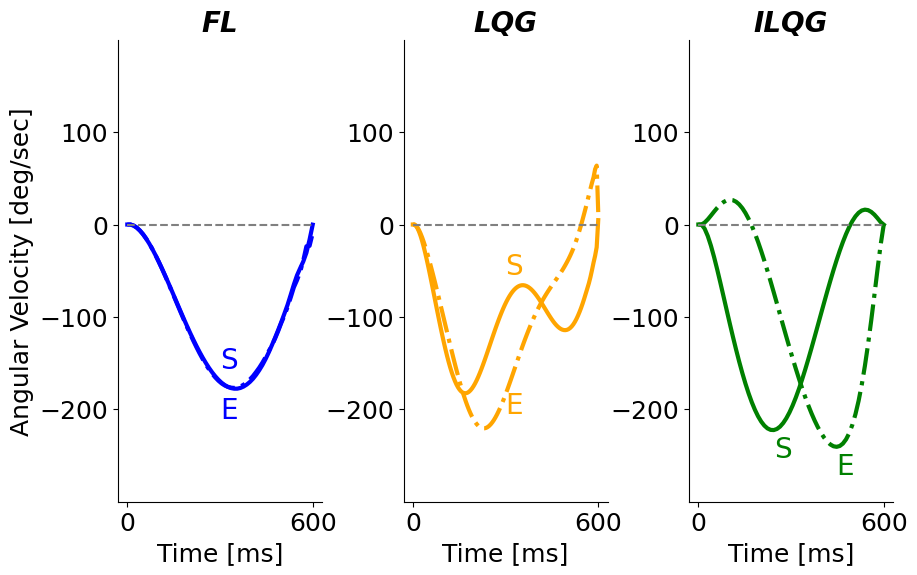

In [10]:
from ILQGController import *
from FLController import *
from matplotlib.patches import Ellipse
st = ToCartesian(np.array([80,120])/180*pi)
tg = ToCartesian(np.array([20,60])/180*pi)
MovementTime = .6
NumIteration = int(MovementTime*100)
Time = np.linspace(0,MovementTime*1000,NumIteration)
plt.figure(figsize = (8,8))

xFL,yFL,jFL,xfl = Feedback_Linearization(Duration=MovementTime,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=NumIteration,starting_point=st,targets=tg,ShowJ=True,plot = False,Delay = .06,Activate_Noise=True)
xILQG,yILQG,uilqg,zilqg=ILQG(MovementTime,1e4,1,1e-5,tg,NumIteration,st,plot = False,Delay = .06,Noise=True)
xLQG,yLQG,ulqg,zlqg=BestLQG(Duration=MovementTime,Num_iter=120,starting_point=st,targets=tg,plot = False,Delay = .06,Activate_Noise=True,MultipleLinearization=False)

jILQG = Cost_Function(1e7,1e3,1e-5,np.concatenate((zilqg[-1,:6],toPolar(tg))),uilqg,rearrange=True)
jLQG = Cost_Function(1e7,1e3,1e-5,zlqg[:,-1],ulqg)
jFL = int(jFL*1000)/1000

plt.plot(xFL,yFL,color = "blue",label = "Feedback \nLinearization",linewidth = 3)
plt.plot(xILQG,yILQG,color = "green",label = "ILQG",linewidth = 3)
plt.plot(xLQG,yLQG,color = "orange",label = "LQG",linewidth = 3)
plt.axis("equal")
plt.yticks([20,40,60])
plt.xticks([-20,0,20])
plt.scatter(tg[0],tg[1],edgecolors='red', facecolors='none', s=100, linewidth=1.5)
ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.axis("off")
plt.plot([-10,0],[20,20],color = "black",linewidth = 2)
plt.text(-8,21,"10cm",fontsize = 20)
MultipleLabel(title="")
plt.show()

fig,ax = plt.subplots(1,3,figsize = (10,6))
Decal = 15
ft = 20

ax[0].plot(Time,xfl[:,2]/pi*180,label="Shoulder",linewidth = 3,color = "blue")
ax[1].plot(np.linspace(0,MovementTime*1000,120),zlqg[1]/pi*180,label = "Shoulder",linewidth = 3,color = "orange")
ax[2].plot(Time,zilqg[:,2]/pi*180,label = "Shoulder",linewidth = 3,color = "green")



ax[0].text(300,(xfl[:,2]/pi*180)[len(xfl[:,2])//2]+Decal,"S",color = "blue",fontsize = ft)
ax[1].text(300,(zlqg[1]/pi*180)[len(zlqg[1])//2]+Decal*2,"S",color = "orange",fontsize = ft)
ax[2].text(Time[np.argmin(zilqg[:,2])],(zilqg[:,2]/pi*180)[np.argmin(zilqg[:,2])]-2*Decal,"S",color = "green",fontsize = ft)

ax[0].text(300,(xfl[:,3]/pi*180)[len(xfl[:,3])//2]-2.5*Decal,"E",color = "blue",fontsize = ft)
ax[1].text(300,(zlqg[4]/pi*180)[len(zlqg[4])//2]-1.5*Decal,"E",color = "orange",fontsize = ft)
ax[2].text(Time[np.argmin(zilqg[:,3])],(zilqg[:,3]/pi*180)[np.argmin(zilqg[:,3])]-2*Decal,"E",color = "green",fontsize = ft
ft = 20
ax[0].set_title("FL",fontsize = ft,fontweight = "bold",style = "italic")
ax[1].set_title("LQG",fontsize = ft,fontweight = "bold",style = "italic")
ax[2].set_title("ILQG",fontsize = ft,fontweight = "bold",style = "italic")





ax[0].plot(Time,xfl[:,3]/pi*180,label="Elbow",linewidth = 3,color = "blue",linestyle = "-.")
ax[1].plot(np.linspace(0,MovementTime*1000,120),zlqg[4]/pi*180,label = "Elbow",linewidth = 3,color = "orange",linestyle = "-.")
ax[2].plot(Time,zilqg[:,3]/pi*180,label = "Elbow",linewidth = 3,color = "green",linestyle = "-.")
ax[0].set_ylabel("Angular Velocity [deg/sec]",fontsize = 18)
for k in range(3):
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['right'].set_visible(False)
    ax[k].tick_params(axis='both', labelsize=18)
    ax[k].set_xlabel("Time [ms]",fontsize = 18)
    ax[k].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")
    ax[k].set_yticks([-200,-100,0,100])
    ax[k].set_ylim(-300,200)
    ax[k].set_xticks([0,MovementTime*1000])

plt.subplots_adjust(wspace=0.4,hspace = 0.3)

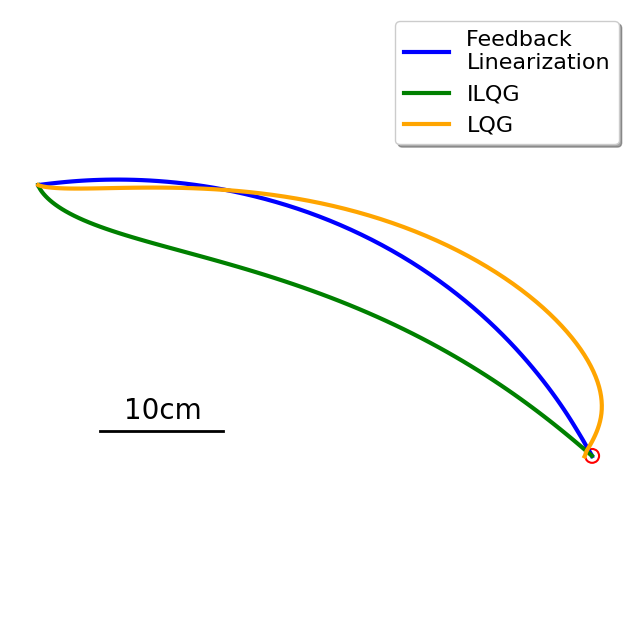

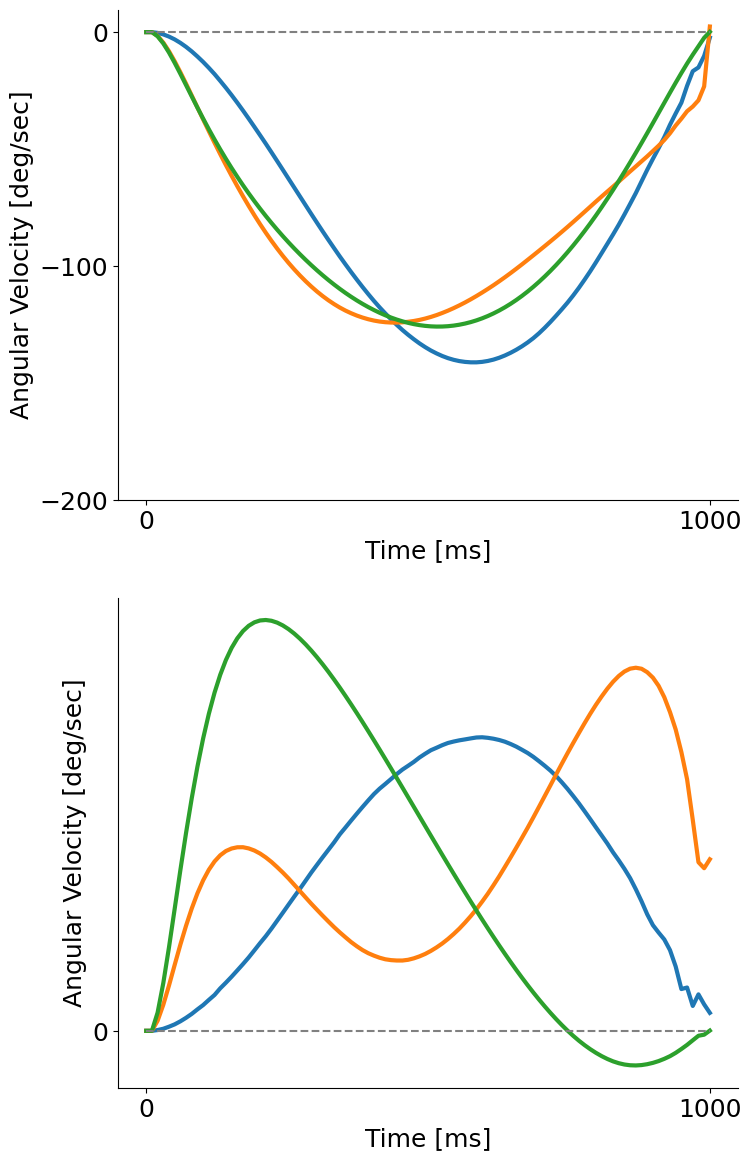

In [10]:
from ILQGController import *
from FLController import *
from matplotlib.patches import Ellipse
st = [-15,50]
tg = [30,28]
MovementTime = 1
NumIteration = int(MovementTime*100)
Time = np.linspace(0,MovementTime*1000,NumIteration)
plt.figure(figsize = (8,8))
xFL,yFL,j,xfl = Feedback_Linearization(Duration=MovementTime,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=NumIteration,starting_point=st,targets=tg,ShowJ=True,plot = False,Delay = .06,Activate_Noise=True)
xILQG,yILQG,u,zilqg=ILQG(MovementTime,1e7,1e3,1e-5,tg,NumIteration,st,plot = False,Delay = .06,Noise=True)
xLQG,yLQG,u,z=BestLQG(Duration=MovementTime,Num_iter=NumIteration,starting_point=st,targets=tg,plot = False,Delay = .06,Activate_Noise=True)
plt.plot(xFL,yFL,color = "blue",label = "Feedback \nLinearization",linewidth = 3)
plt.plot(xILQG,yILQG,color = "green",label = "ILQG",linewidth = 3)
plt.plot(xLQG,yLQG,color = "orange",label = "LQG",linewidth = 3)
plt.axis("equal")
plt.yticks([20,40,60])
plt.xticks([-20,0,20])
plt.scatter([30],[28],edgecolors='red', facecolors='none', s=100, linewidth=1.5)
ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.axis("off")
plt.plot([-10,0],[30,30],color = "black",linewidth = 2)
plt.text(-8,31,"10cm",fontsize = 20)
MultipleLabel(title="")
plt.show()

fig,ax = plt.subplots(2,figsize = (8,14))

for k in range(2):
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['right'].set_visible(False)
    ax[k].tick_params(axis='both', labelsize=18)
    ax[k].set_xlabel("Time [ms]",fontsize = 18)
    ax[k].set_ylabel("Angular Velocity [deg/sec]",fontsize = 18)
ax[0].plot(Time,xfl[:,2]/pi*180,label="FL",linewidth = 3)
ax[0].plot(Time,z[1]/pi*180,label = "LQG",linewidth = 3)
ax[0].plot(Time,zilqg[:,2]/pi*180,label = "ILQG",linewidth = 3)
ax[0].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")
ax[0].set_yticks([0,-100,-200])
ax[0].set_xticks([0,MovementTime*1000])
ax[1].set_xticks([0,MovementTime*1000])
ax[1].set_yticks([0,100,200])




ax[1].plot(Time,xfl[:,3]/pi*180,label="FL",linewidth = 3)
ax[1].plot(Time,z[4]/pi*180,label = "LQG",linewidth = 3)
ax[1].plot(Time,zilqg[:,3]/pi*180,label = "ILQG",linewidth = 3)
ax[1].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")

(50, 6)


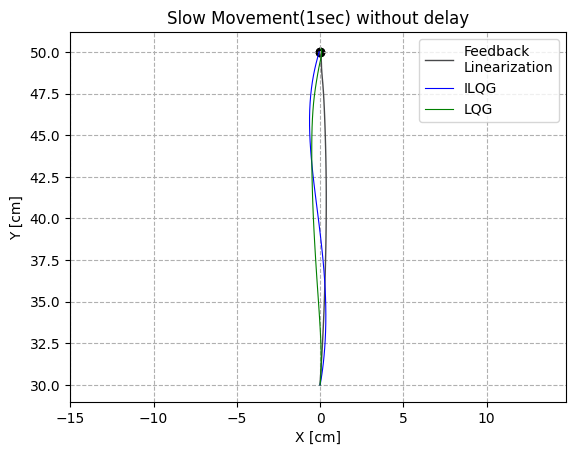

(50, 6)


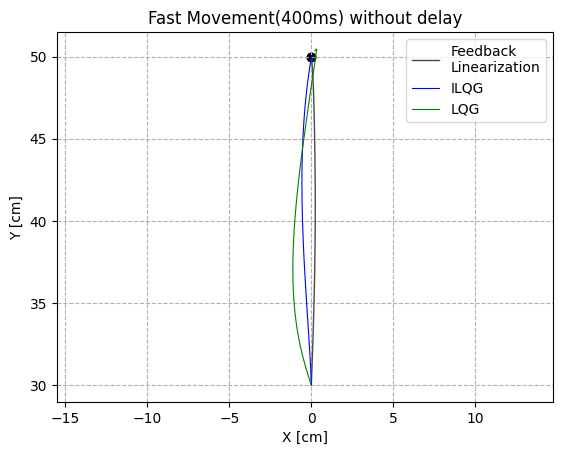

(50, 24)


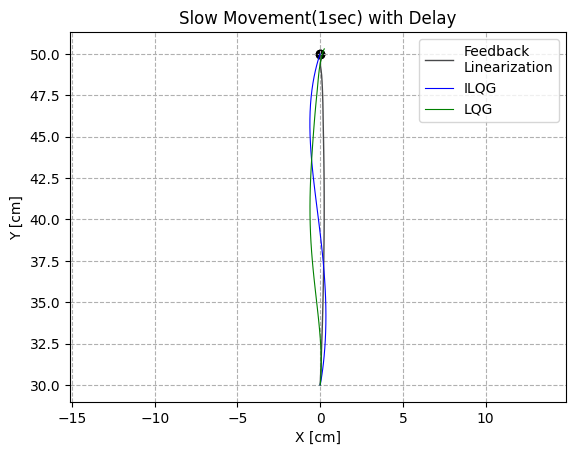

(50, 48)


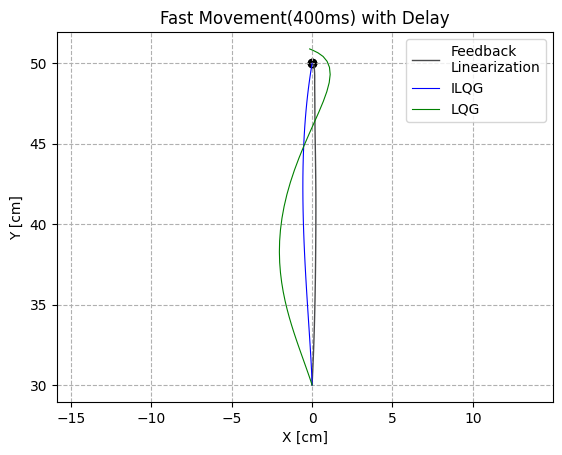

In [11]:
from ILQGController import *
from FLController import *
for Delay in [0,0.06]:
    for Duration in [1,.4]:
        x,y,j,xfl = Feedback_Linearization(Duration=Duration,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=50,starting_point=[0,30],targets=[0,50],ShowJ=True,Activate_Noise=True,Delay=Delay)
        x,y,u,zilqg=ILQG(Duration,1e7,1e3,1e-5,[0,50],50,[0,30],Noise=True,Delay=Delay)
        print(zilqg.shape)
        x,y,u,z=BestLQG(Duration=Duration,Num_iter=50,starting_point=[0,30],targets=[0,50],Activate_Noise=True,Delay=Delay)
        plt.legend()
        title1 = "Slow Movement(1sec)" if Duration == 1 else "Fast Movement(400ms)"
        title2 = " without delay" if Delay == 0 else " with Delay"
        plt.title(title1+title2)
        plt.show()
    #x,y,u=BestLQG(Duration=.6,Num_iter=120,MultipleLinearization=True)

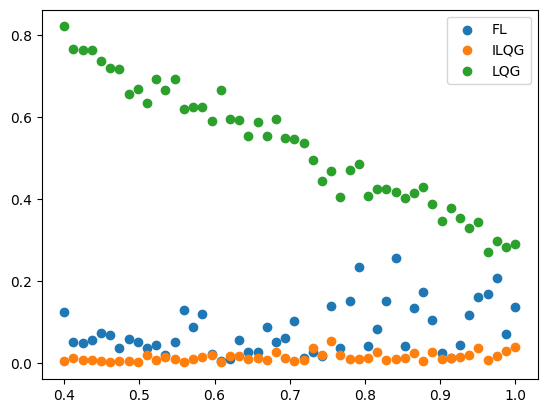

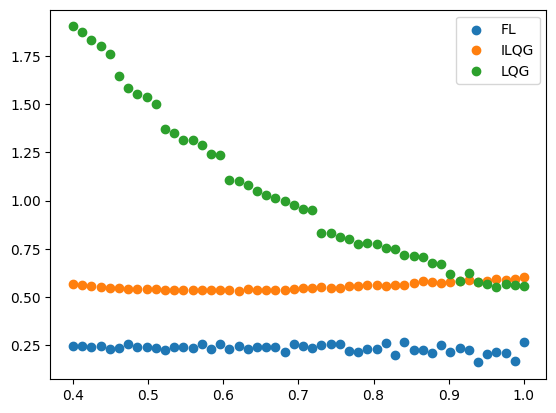

In [12]:
from ILQGController import *
from FLController import *

Delay = .06
Error = np.zeros((6,50))
D = np.linspace(0.4,1,50)
for i,Duration in enumerate(D):
        x,y,j,xfl = Feedback_Linearization(Duration=Duration,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=60,starting_point=[0,30],targets=[0,50],ShowJ=True,Activate_Noise=True,Delay=Delay,plot = False)
        Error[0,i] = np.sqrt((x[-1])**2+(y[-1]-50)**2)
        Error[3,i] = np.max(np.abs(x))
        x,y,u,zilqg=ILQG(Duration,1e7,1e3,1e-5,[0,50],60,[0,30],Noise=True,Delay=Delay,plot = False)
        Error[1,i] = np.sqrt((x[-1])**2+(y[-1]-50)**2)
        Error[4,i] = np.max(np.abs(x))
        x,y,u,z=BestLQG(Duration=Duration,Num_iter=60,starting_point=[0,30],targets=[0,50],Activate_Noise=True,Delay=Delay,plot = False)
        Error[2,i] = np.sqrt((x[-1])**2+(y[-1]-50)**2)
        Error[5,i] = np.max(np.abs(x))

LABELS = ["FL","ILQG","LQG"]
for i in range(3):
        plt.scatter(D,Error[i],label = LABELS[i])
plt.legend()
plt.show()

for i in range(3,6):
        plt.scatter(D,Error[i],label = LABELS[i-3])
plt.legend()
plt.show()

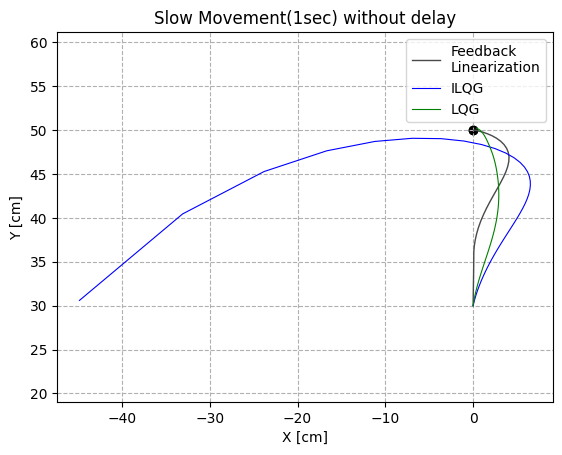

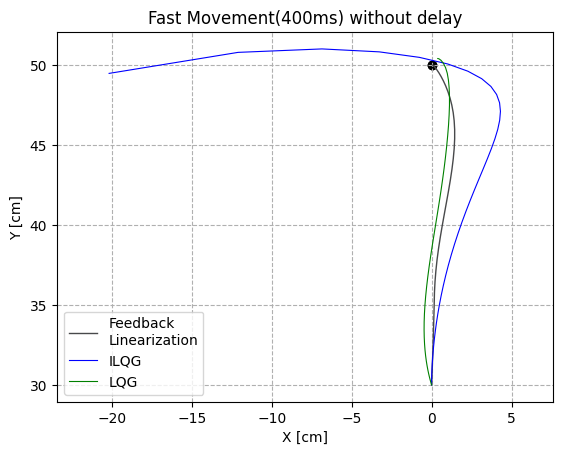

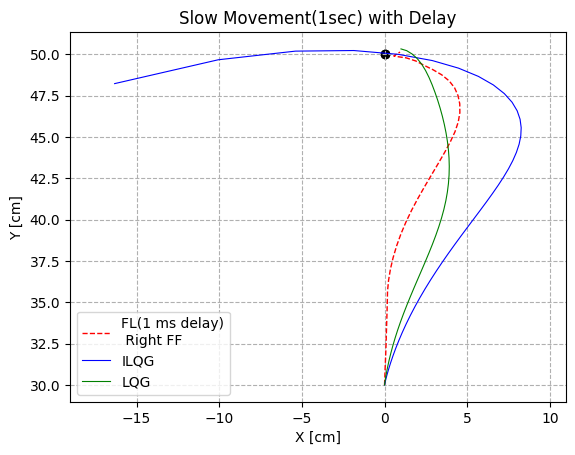

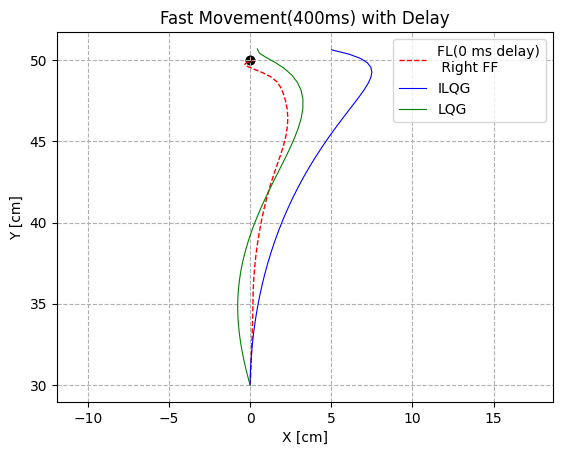

In [13]:
from ILQGController import *
from FLController import *
for Delay in [0,0.06]:
    for Duration in [1,.4]:
        x,y,j,xfl = Feedback_Linearization(Duration=Duration,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=50,starting_point=[0,30],targets=[0,50],ShowJ=True,Activate_Noise=True,Delay=Delay,AdditionalDynamics={"FF":True,"FFonset":35,"Side":"Right"})
        x,y,u,zilqg=ILQG(Duration,1e7,1e3,1e-5,[0,50],50,[0,30],Noise=True,Delay=Delay,FF=True,Side="Right")
        x,y,u,z=BestLQG(Duration=Duration,Num_iter=50,starting_point=[0,30],targets=[0,50],Activate_Noise=True,Delay=Delay,FF=True)
        plt.legend()
        title1 = "Slow Movement(1sec)" if Duration == 1 else "Fast Movement(400ms)"
        title2 = " without delay" if Delay == 0 else " with Delay"
        plt.title(title1+title2)
        plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a simple plot
fig, ax = plt.subplots()

# Plot an arrow going to the right
ax.annotate('', xy=(3, 0), xytext=(1, 0),
            arrowprops=dict(facecolor='blue', edgecolor='blue', arrowstyle="->", lw=2))

# Add the text above the arrow using LaTeX formatting
ax.text(1.5, 0.1, r'$F_x = k\dot{y}$', fontsize=14, ha='center')

# Set limits and labels to make the plot clear
ax.set_xlim(-1, 4)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')

# Show the plot
plt.show()

ImportError: Failed to import any of the following Qt binding modules: PyQt6, PySide6, PyQt5, PySide2

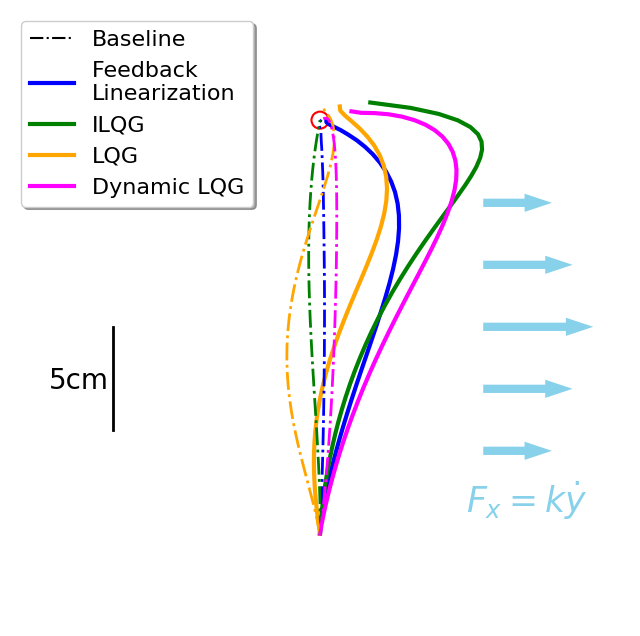

In [60]:
from ILQGController import *
from FLController import *
from matplotlib.patches import Ellipse
from matplotlib.patches import FancyArrow
st = [0,30]
tg = [0,50]
MovementTime = .5
NumIteration = int(MovementTime*100)
Time = np.linspace(0,MovementTime*1000,NumIteration)
side = "Right"
plt.figure(figsize = (8,8))
lw = [3,2]
ls = ["-","-."]
plt.plot([0,0],[30,30],color = "black",linestyle = "-.",label = "Baseline")
for i,activation in enumerate([True,False]):
    xFL,yFL,j,xfl = Feedback_Linearization(Duration=MovementTime,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=NumIteration,starting_point=st,targets=tg,ShowJ=True,plot = False,AdditionalDynamics={"FF":activation,"FFonset":30,"Side":side},Delay = .06,Activate_Noise=True)
    xILQG,yILQG,u,zilqg=ILQG(MovementTime,1e7,1e3,1e-5,tg,NumIteration,st,plot = False,Delay = .06,Noise=True,FF=activation,Side=side)
    xLQG,yLQG,u,z=BestLQG(Duration=MovementTime,Num_iter=NumIteration,starting_point=st,targets=tg,plot = False,Delay = .06,Activate_Noise=True,FF=activation,Side=side)
    xLQG2,yLQG2,u,z=BestLQG(Duration=MovementTime,Num_iter=NumIteration,starting_point=st,targets=tg,plot = False,Delay = .06,Activate_Noise=True,FF=activation,Side=side,MultipleLinearization=True)
    plt.plot(xFL,yFL,color = "blue",label = "Feedback \nLinearization",linewidth = lw[i],linestyle = ls[i])
    plt.plot(xILQG,yILQG,color = "green",label = "ILQG",linewidth = lw[i],linestyle = ls[i])
    plt.plot(xLQG,yLQG,color = "orange",label = "LQG",linewidth = lw[i],linestyle = ls[i])
    plt.plot(xLQG2,yLQG2,color = "magenta",label = "Dynamic LQG",linewidth = lw[i],linestyle = ls[i])
    
    if i == 0: MultipleLabel(title="",side="left")
plt.axis("equal")
plt.yticks([30,40,50])
plt.xticks([-10,0,10])
plt.xlim(-15,15)
plt.scatter([tg[0]],[tg[1]],edgecolors='red', facecolors='none', s=150, linewidth=1.5)
ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.axis("off")
plt.plot([-10,-10],[35,40],color = "black",linewidth = 2)
plt.text(-13.1,37,"5cm",fontsize = 20)

Y = [35,38,41,44,47]
DY = [2,3,4,3,2]
mycolor = "#87d1eb"
for i in range(5):
    arrow = FancyArrow(x=8, y=Y[i]-1, dx=DY[i], dy=0, width=0.2, edgecolor=mycolor, facecolor=mycolor, linewidth=3)
    ax.add_patch(arrow)
# Add the arrow to the plot



# Add the text above the arrow using LaTeX formatting
ax.text(10,31, r'$F_x = k\dot{y}$', fontsize=25, ha='center',color = mycolor, fontweight='bold')
plt.show()


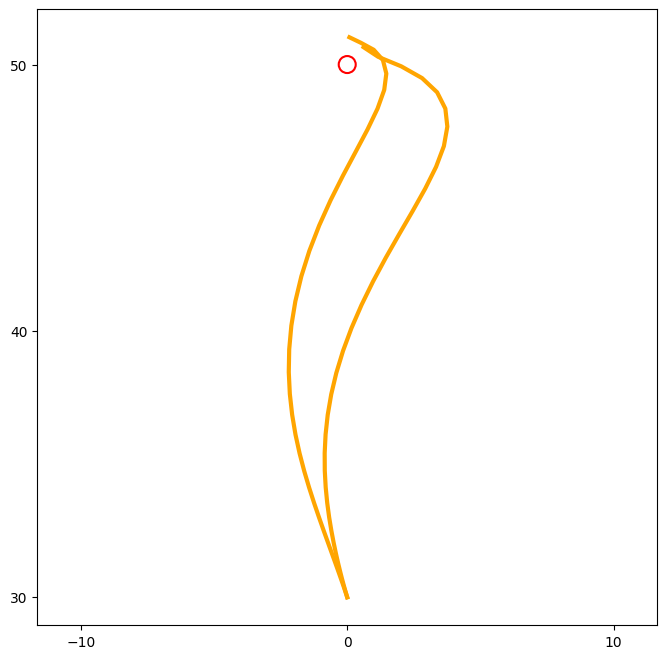

In [16]:
st = [0,30]
tg = [0,50]
MovementTime = .4
NumIteration = int(MovementTime*100)
Time = np.linspace(0,MovementTime*1000,NumIteration)
side = "Right"
plt.figure(figsize = (8,8))
xLQG,yLQG,u,z=BestLQG(Duration=MovementTime,Num_iter=NumIteration,starting_point=st,targets=tg,plot = False,Delay = .06,Activate_Noise=True,FF=True,Side=side)
plt.plot(xLQG,yLQG,color = "orange",label = "LQG",linewidth = 3)
xLQG,yLQG,u,z=BestLQG(Duration=MovementTime,Num_iter=NumIteration,starting_point=st,targets=tg,plot = False,Delay = .06,Activate_Noise=True,FF=False,Side=side)
plt.plot(xLQG,yLQG,color = "orange",label = "LQG",linewidth = 3)
plt.axis("equal")
plt.yticks([30,40,50])
plt.xticks([-10,0,10])
plt.xlim(-15,15)
plt.scatter([tg[0]],[tg[1]],edgecolors='red', facecolors='none', s=150, linewidth=1.5)
ax = plt.gca()